In [1]:
import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit
import cProfile

In [2]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)

        for k in range(50):
            s ='x0_'+str(k)
            if not s in var:
                var.append(s)
            s ='y0_'+str(k)
            if not s in var:
                var.append(s)
            s ='x1_'+str(k)
            if not s in var:
                var.append(s)
            s ='y1_'+str(k)
            if not s in var:
                var.append(s)
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

In [3]:
def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    tdd_new=renormalize(tdd_new)
    return tdd_new

def eliminate_global_map(tdd):
    n = int(tdd.key_2_index[0][1:])+1
    # n = tdd.node.key//2+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    the_map = tdd.map
    while the_map.level>-1:
        q = int(tdd.key_2_index[the_map.level][1:])
        # q = n-1-the_map.level//2
        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.rotate>0:
                cir_head.p(np.pi/4*(8-the_map.rotate),q)
            if the_map.x==1:
                cir_head.x(q)
        else:
            if the_map.x==1:
                cir_end.x(q)
            if the_map.rotate>0:
                cir_end.p(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
    
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end

def eliminate_control(tdd,x,the_map):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    q_c = int(tdd.key_2_index[x][1:])
    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
            continue
        q = int(tdd.key_2_index[the_map.level][1:])
#         print(q_c,q)

        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.x==1:
                cir_head.cx(q_c,q)
            if the_map.rotate>0:
                cir_head.cp(np.pi/4*(8-the_map.rotate),q_c,q)
        else:
            if the_map.x==1:
                cir_end.cx(q_c,q)
            if the_map.rotate>0:
                cir_end.cp(np.pi/4*(8-the_map.rotate),q_c,q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end


def reduced_two_qubit(tdd):
    # if tdd.map.level!=-1:
    #     return False

    the_map = tdd.node.successor[0].out_maps[1]
    if the_map.level!=1:
        return True
    
    the_map = tdd.node.out_maps[1]
    if the_map.level==0:
        return False
    while the_map.level>0:
        the_map = the_map.father
    if the_map.level==0:
        return False
            
    return True

def reduce_hadamard(tdd):
    n = 2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    if reduced_two_qubit(tdd):
        return tdd,cir_head,cir_end

    # for k in range(16):
    #     a=bin(k)[2:]
    #     a='0'*(4-len(a))+a
    #     cir_head = QuantumCircuit(n)
    #     cir_end = QuantumCircuit(n)
    
    #     tdd_temp=tdd.self_copy()
    #     if a[3]=='0':
    #         cir_head.h(0)
    #     if a[2]=='0':
    #         cir_end.h(0)
    #     if a[1]=='0':
    #         cir_head.h(1)
    #     if a[0]=='0':
    #         cir_end.h(1)
        
    #     tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
    #     if reduced_two_qubit(tdd_new):
    #         return tdd_new,cir_head,cir_end
    # print('Not Done0')
    for k in range(2):
        a=bin(k+1)[2:]
        a='0'*(2-len(a))+a
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
        tdd_temp=tdd.self_copy()
        if a[1]=='0':
            cir_head.cz(0,1)
            cir_head.h(0)
            cir_head.h(1)
            cir_head.cz(0,1)
        if a[0]=='0':
            cir_end.cz(0,1)
            cir_end.h(0)
            cir_end.h(1)
            cir_end.cz(0,1)
        
        tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
        if reduced_two_qubit(tdd_new):
            return tdd_new,cir_head,cir_end

    for k in range(2):
        a=bin(k+1)[2:]
        a='0'*(2-len(a))+a
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
        tdd_temp=tdd.self_copy()
        if a[1]=='0':
            cir_head.cz(0,1)
            cir_head.h(0)
            cir_head.h(1)
            cir_head.cz(0,1)
            cir_head.h(0)
            cir_head.h(1)
            cir_head.cz(0,1)            
        if a[0]=='0':
            cir_end.cz(0,1)
            cir_end.h(0)
            cir_end.h(1)
            cir_end.cz(0,1)
            cir_end.h(0)
            cir_end.h(1)
            cir_end.cz(0,1)            
        
        tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
        if reduced_two_qubit(tdd_new):
            return tdd_new,cir_head,cir_end  
        
    # for k in range(4):
    #     a=bin(k)[2:]
    #     a='0'*(2-len(a))+a
    #     cir_head = QuantumCircuit(n)
    #     cir_end = QuantumCircuit(n)
    #     tdd_temp=tdd.self_copy()
    #     if a[1]=='0':
    #         cir_head.cx(1,0)
    #     if a[0]=='0':
    #         cir_end.cx(1,0)
        
    #     tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
    #     if reduced_two_qubit(tdd_new):
    #         return tdd_new,cir_head,cir_end
    #     # print(k)
    
    return None,cir_head,cir_end

def eliminate_top_level(tdd):
    
    the_map1 = tdd.node.out_maps[1]
    tdd_new,cir_head,cir_end = eliminate_control(tdd,tdd.node.key,the_map1)
    
    the_map2 = tdd.node.successor[0].out_maps[1]
    tdd_new2,cir_head2,cir_end2 = eliminate_control(tdd_new,tdd.node.successor[0].key,the_map2)
    
    
#     if tdd.node.successor[0]!=tdd.node.successor[1]:
#         print('Still split 0')
        
#     if tdd.node.successor[0].successor[0]!=tdd.node.successor[0].successor[1]:
#         print('Still split 1')
        
#     the_map1 = tdd_new2.node.out_maps[1]
#     the_map2 = tdd_new2.node.successor[0].out_maps[1]
    
#     if the_map1.level=tdd_new2.node.key-1:
#         the_map1=the_map1.father
        
#     if the_map1.level>-1 and the_map2.level>-1:
    
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2
    
def syn(tdd):
    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    tdd_new2,cir_head2,cir_end2=eliminate_top_level(tdd_new)
    tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
    return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3

30
60
90


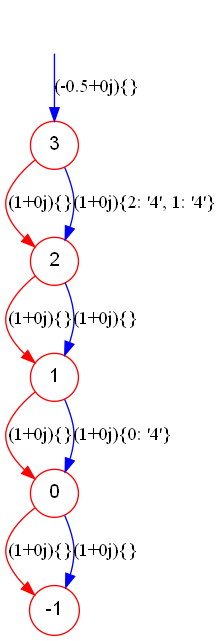

In [4]:
n=2
m=10
k=0
while(k<100):
    
    cir=gen_cir('Random_Clifford',n,m)
    tdd=simulate(cir,True)
    # tdd.show(False)
    tdd_new,cir_head,cir_end=syn(tdd)
    if reduced_two_qubit(tdd_new):
        continue
    else:
        tdd_new2,cir_head,cir_end = reduce_hadamard(tdd_new)
        if not tdd_new2:
            print('Counter Example')
            break
    if k%30==0 and k>0:
        print(k)
    k+=1
tdd_new2.show(False)
# cir_end.draw()

In [5]:
# f=open('cannot be reduced by h.qasm','w')
# f.write(cir.qasm())
# f.close()

In [6]:
# cir=QuantumCircuit(2)
# # cir.cx(1,0)
# cir.h(0)
# cir.cz(0,1)
# cir.h(0)
# cir.h(1)
# cir.cz(0,1)
# tdd222=simulate(cir,True)
# tdd_new222,cir_head,cir_end=syn(tdd222)
# print(cir_head.qasm())
# print(cir_end.qasm())
# tdd_new222.show()

1